# Networks of Exc and Inh Spiking Neurons (Leaky Integrate & Fire)

Aditya Gilra  
CAMP 2016 @ Bangalore

<img src='files/redneuronal-1024x768_mattcognitivescienceblog.jpg'>  
Image from http://mattscognitivescienceblog.wordpress.com/2013/07/18/connectionism-part-3/  

![](brian1.png)  
- http://briansimulator.org/  
- "a simulator should not only save the time of processors, but also the time of scientists."
- python based
- easy to prototype arbitrary neurons/synapse models
- version 2rc3
- http://brian2.readthedocs.io/en/2.0rc3/
- http://brian2.readthedocs.io/en/2.0rc3/examples/index.html
- https://brian2tools.readthedocs.io/en/stable/

In [1]:
%matplotlib inline
#%matplotlib qt
from brian2 import *

defaultclock.dt = 0.1*ms

## Units, Equations, NeuronGroup

+ Brian imposes units (1,second,ms,volt,mV,amp,nA,...SI names)
+ Equations: first-order differential equations, parameters, sub-expressions
+ Simulate 1000 LIF neurons without synaptic connections

In [4]:
eqs_neurons='''
inp : volt
dv/dt = (-v + inp)/(20*ms) : volt
'''
P=NeuronGroup(N=1000,model=eqs_neurons,\
                threshold='v>=20*mV',reset='v=10*mV',\
                refractory=10*ms,method='euler')
P.v = 0.*mV
P.inp = uniform(size=(1000)) * 40*mV

## Monitors, run, plot

Starting simulation at t=0. s for a duration of 100. ms
100. ms (100%) simulated in < 1s


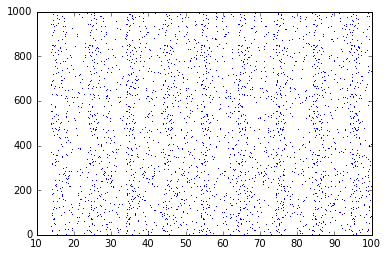

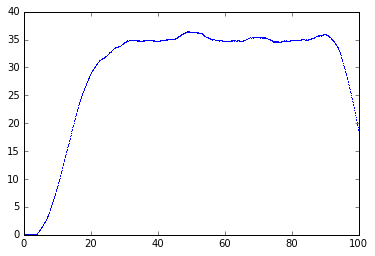

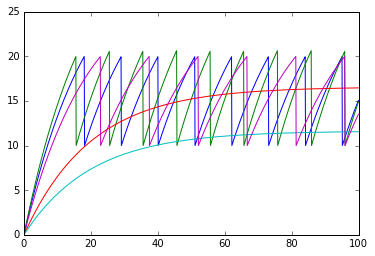

In [5]:
sm = SpikeMonitor(P)
sr = PopulationRateMonitor(P)
sm_vm = StateMonitor(P,'v',record=range(5))

run(100*ms, report='text')

figure()
plot(sm.t/ms,sm.i,',');
figure()
plot(sr.t/ms,sr.smooth_rate(width=5*ms)/Hz,',');
figure()
plot(sm_vm.t/ms,transpose(sm_vm.v/mV));

## Synapses

+ Set up connections between these neurons
+ state evolution equations
+ event-based updates, on_pre & on_post
+ Simulate for varying strengths of these connections

In [ ]:
# delta-function synapses
con = Synapses(P,P,'w:volt (constant)',on_pre='v_post+=w',method='euler')
con.connect(condition='i!=j',p=0.1)
con.delay = 1*ms
con.w['i<800'] = 0.1*mV
con.w['i>=800'] = -5*0.1*mV


Starting simulation at t=0. s for a duration of 100. ms
100. ms (100%) simulated in < 1s


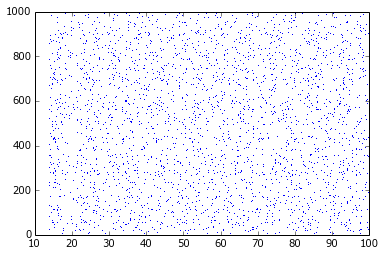

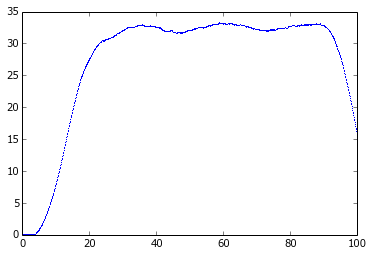

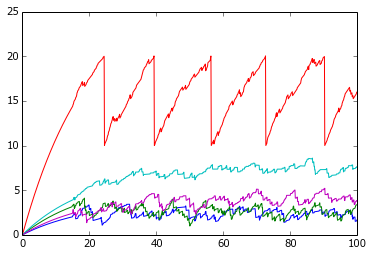

In [1]:
%matplotlib inline
#%matplotlib qt
from brian2 import *

defaultclock.dt = 0.1*ms

eqs_neurons='''
inp : volt
dv/dt = (-v + inp)/(20*ms) : volt
'''
P=NeuronGroup(N=1000,model=eqs_neurons,\
                threshold='v>=20*mV',reset='v=10*mV',\
                refractory=2*ms,method='euler')
P.v = 0.*mV
P.inp = uniform(size=(1000)) * 40*mV

# delta-function synapses
con = Synapses(P,P,'w:volt (constant)',on_pre='v_post+=w',method='euler')
con.connect(condition='i!=j',p=0.1)
con.delay = 1*ms
con.w['i<800'] = 0.1*mV
con.w['i>=800'] = -5*0.1*mV

sm = SpikeMonitor(P)
sr = PopulationRateMonitor(P)
sm_vm = StateMonitor(P,'v',record=range(5))

run(100*ms, report='text')

figure()
plot(sm.t/ms,sm.i,',');
figure()
plot(sr.t/ms,sr.smooth_rate(width=5*ms)/Hz,',');
figure()
plot(sm_vm.t/ms,transpose(sm_vm.v/mV));

## Brunel (2000) EI network

- NE=10000 exc and NI=2500 inh LIF neurons
- CE=p\*NE exc and CI=p\*NI inh connections per neuron (p = 0.1)
- delta-function synapses
- 0.1mV exc and -g*0.1mV inh weights (g=5)
- mean external input = inpfactor \* threshold voltage (via 12500 spike trains)

### Spiking input

In [ ]:
inpfactor = 2
nu_thr = vth/(p*NE*J*tau)
Pinp = PoissonGroup(N=N,rates=inpfactor*nu_thr)

# connect these Pinp neurons to the P neurons

### Asynchronous Irregular (AI) activity

- run "STEP2_ExcInhNet_Brunel2000_brian2_prob.py"
- Is the activity AI?

- Plot only 50 neurons for 200ms. Compare with below:
<img src='files/Brunel2000_fig8C.png'>  

### Remedying the irregularity

- Have a fixed CE number of exc and CI of inh connections, not a probability
- Probability gives rise to a binomial distribution of input synapses per neuron (with mean CE and CI)  
<img src='files/binomial.png'>  
- Disrupts the EI balance in some neurons
- con.connect(i=conn_i,j=conn_j) # conn_i and conn_j are vectors of corresponding pre i and post j neuronal indices

- STEP3_ExcInhNet_Brunel2000_brian2.py
- Ideally, fixed number of synapses for input connections also

## Phase diagram for Brunel (2000) network

<img src='files/Brunel2000_fig2A.png'>  

- Verify phase diagram in Brunel (2000) for different g and nu_ext
- A. $g=3, \nu_{ext}/\nu_{thr}=2$
- B. $g=6, \nu_{ext}/\nu_{thr}=4$
- C. $g=5, \nu_{ext}/\nu_{thr}=2$
- D. $g=4.5, \nu_{ext}/\nu_{thr}=0.9$

<img src='files/Brunel_fig8_params.png'>  

Plot a histogram of the co-eff of variation of inter-spike intervals

How can you increase it?

## Ostojic (2014)
Vary the connections strength J and see the behaviour of instantaneous firing rates a la Ostojic (2014).

+ Plot rate vs time for say 10 individual neurons.
+ Set J=0.2mV or J=0.8mV to reproduce result from Ostojic, 2014  
+ Note the CV distribution also

<img src='files/Ostojic2014_result.png'>

## Sparse Strong Weak Dense network (Fukai lab 2012, 2013)

- EI network of LIF neurons, but conductance-based synapses
- 0.1 & 0.5 probability of E & I connections
- constant E-to-I, I-to-E, and I-to-I weights
- E-to-E weights are distributed lognormally (Song et al 2005)
  + causes persistent activity without external input
  + log-normal distribution of firing rates
<img src='files/Songetal2005_fig5b.png'>

Try Gaussian instead of log-normal distribution of E-to-E synapses.

- can build on this for associative memory model
- play with delay, jitter in delay, probabilistic release...